## 1. Import Toolkits and Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge,Lasso,ElasticNet  
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR  
import lightgbm as lgb 
from xgboost import XGBRFRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## 2. Loading data

### 2.1 Non-dimensionality-reduced data

In [2]:
all_data = pd.read_csv('./processed_zhengqi_data2.csv')

# Training Data
cond = all_data['label'] == 'train'
train_data = all_data[cond]
train_data.drop(labels = 'label',axis = 1,inplace = True)

# Extract feature data X and target value y from training data
X = train_data.drop(labels='target',axis = 1)
y = train_data['target']

# Split data: training data 80% validation data 20%
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.2)

# Test submission data
cond2 = all_data['label'] == 'test'
submit_test = all_data[cond2]
submit_test.drop(labels = ['label','target'],axis = 1,inplace = True)

### 2.2 Dimensionality reduction data

In [3]:
#Data with PCA feature preservation
X_pca = np.load('./train_data_pca.npz')['X_train']
y_pca = np.load('./train_data_pca.npz')['y_train']

# Split data: training data 80% validation data 20%
X_train_pca,X_valid_pca,y_train_pca,y_valid_pca=train_test_split(X_pca,y_pca,
                                                               test_size=0.2)
submit_test_pca = np.load('./test_data_pca.npz')['X_test']

## 3. GridSearchCV algorithm parameter adjustment

#### This function For machine learning model parameter tuning
#### Use grid search and cross validation to optimize the model parameters
#### And evaluate the performance of the model on the training data. 
#### The function returns the best model, cross-validation score statistics, and the complete grid search results

In [4]:
def train_model(model, param_grid=[], X=[], y=[],splits=5, repeats=5):
    # model: The machine learning model to optimize, such as LGBMRegressor
    # param_grid: The search range of the hyperparameters (in dictionary form)
    # X, y: features of training data and target values
    # splits: The number of cross-validation splits, the default is 5
    # repeats: The number of cross-validation repetitions, the default is 5
    
    # Creating a Grid Intersection
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    # Setting grid search parameters
    gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                           scoring='neg_mean_squared_error',# mean_squared_error
                           verbose=1, return_train_score=True)

    # Grid Search Training
    gsearch.fit(X,y)

    # Extracting the best algorithm
    model = gsearch.best_estimator_        

    # Get the average score and standard deviation of the optimal algorithm
    best_idx = gsearch.best_index_ # Optimal Algorithm Index
    grid_results = pd.DataFrame(gsearch.cv_results_)       
    cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
    cv_std = grid_results.loc[best_idx,'std_test_score']
    
    # Merging mean and variance data
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # Predict
    y_pred = model.predict(X)
    
    # Output model evaluation indicators
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X,y))
    print('mse=',mean_squared_error(y, y_pred))
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    
    # Residual Value Visualization
    y_pred = pd.Series(y_pred,index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid 
    n_outliers = sum(abs(z)>3)
    
    plt.figure(figsize=(15,5))
    ax1 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    
    ax2=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    
    ax3=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax3)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))

    return model, cv_score, grid_results

## 4. Using grid search optimization on non-dimensionality-reduced data

In [5]:
# Optional Models
opt_models = dict()
# Documenting Model Performance
score_models = pd.DataFrame(columns=['mean','std'])

splits = 5
repeats = 5

### 4.1 Ridge Regression

Fitting 25 folds for each of 25 candidates, totalling 625 fits
----------------------
Ridge(alpha=0.1)
----------------------
score= 0.8883271191371976
mse= 0.10269372298726444
cross_val: mean= 0.10525923246135696 , std= 0.004014219851107885


Text(0, 0.5, 'mse')

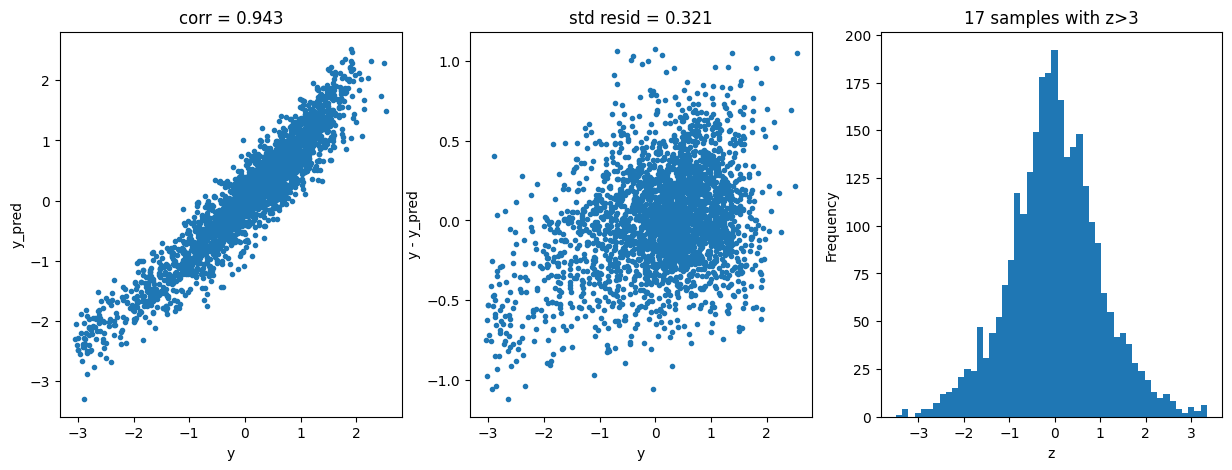

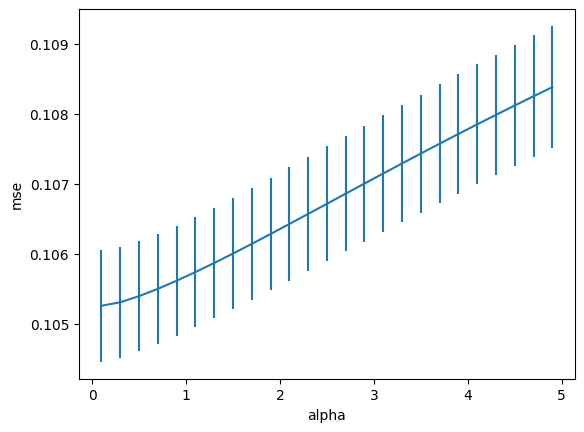

In [7]:
model = 'Ridge'
opt_models[model] = Ridge()

alphas = np.arange(0.1,5,0.2)
param_grid = {'alpha': alphas}

opt_models[model],cv_score,grid_results = train_model(opt_models[model],
                                                      param_grid=param_grid,
                                                      X = X,y = y,
                                                      splits=splits, repeats=repeats)

cv_score.name = model
score_models = pd.concat([score_models, cv_score.to_frame().T])

plt.figure()
plt.errorbar(alphas, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('mse')

In [8]:
alphas.shape

(25,)

In [9]:
score_models

,mean,std
Ridge,0.105259,0.004014


In [10]:
grid_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split17_train_score,split18_train_score,split19_train_score,split20_train_score,split21_train_score,split22_train_score,split23_train_score,split24_train_score,mean_train_score,std_train_score
0,0.001270,0.001386,0.001132,0.003066,0.1,{'alpha': 0.1},-0.104387,-0.105682,-0.098547,-0.099803,...,-0.101742,-0.103160,-0.101521,-0.102569,-0.102559,-0.102039,-0.103571,-0.101173,-0.102415,0.001014
1,0.002298,0.005311,0.000375,0.001391,0.3,{'alpha': 0.30000000000000004},-0.104486,-0.105718,-0.098727,-0.099912,...,-0.101824,-0.103255,-0.101632,-0.102697,-0.102645,-0.102132,-0.103627,-0.101272,-0.102508,0.001007
2,0.000321,0.000677,0.001350,0.004155,0.5,{'alpha': 0.5000000000000001},-0.104591,-0.105829,-0.098912,-0.099987,...,-0.101933,-0.103378,-0.101767,-0.102857,-0.102754,-0.102254,-0.103705,-0.101395,-0.102626,0.001000
3,0.001668,0.004211,0.000181,0.000377,0.7,{'alpha': 0.7000000000000001},-0.104700,-0.105969,-0.099093,-0.100050,...,-0.102058,-0.103511,-0.101909,-0.103027,-0.102873,-0.102387,-0.103796,-0.101526,-0.102754,0.000994
4,0.002477,0.005675,0.000220,0.000526,0.9,{'alpha': 0.9000000000000001},-0.104815,-0.106123,-0.099270,-0.100113,...,-0.102192,-0.103650,-0.102053,-0.103202,-0.102997,-0.102529,-0.103896,-0.101662,-0.102889,0.000989
5,0.002221,0.005169,0.000785,0.003018,1.1,{'alpha': 1.1000000000000003},-0.104934,-0.106285,-0.099444,-0.100178,...,-0.102334,-0.103795,-0.102199,-0.103379,-0.103126,-0.102678,-0.104004,-0.101801,-0.103029,0.000985
6,0.000000,0.000000,0.002460,0.005241,1.3,{'alpha': 1.3000000000000003},-0.105059,-0.106452,-0.099615,-0.100248,...,-0.102482,-0.103944,-0.102347,-0.103559,-0.103258,-0.102832,-0.104117,-0.101944,-0.103173,0.000982
7,0.000710,0.003120,0.002157,0.005200,1.5,{'alpha': 1.5000000000000004},-0.105188,-0.106620,-0.099785,-0.100324,...,-0.102635,-0.104096,-0.102495,-0.103740,-0.103393,-0.102989,-0.104236,-0.102089,-0.103320,0.000980
8,0.000691,0.003034,0.000653,0.003059,1.7,{'alpha': 1.7000000000000004},-0.105321,-0.106790,-0.099952,-0.100404,...,-0.102791,-0.104250,-0.102645,-0.103922,-0.103529,-0.103151,-0.104358,-0.102235,-0.103469,0.000977
9,0.001332,0.004366,0.000664,0.003060,1.9,{'alpha': 1.9000000000000004},-0.105457,-0.106959,-0.100118,-0.100489,...,-0.102950,-0.104405,-0.102794,-0.104105,-0.103667,-0.103314,-0.104482,-0.102383,-0.103620,0.000976


### 4.2 Lasso Regression

Fitting 25 folds for each of 23 candidates, totalling 575 fits
----------------------
Lasso(alpha=0.00018000000000000004)
----------------------
score= 0.8881666328007269
mse= 0.10284130527629844
cross_val: mean= 0.10527946294275442 , std= 0.006506123787447391


Text(0, 0.5, 'mse')

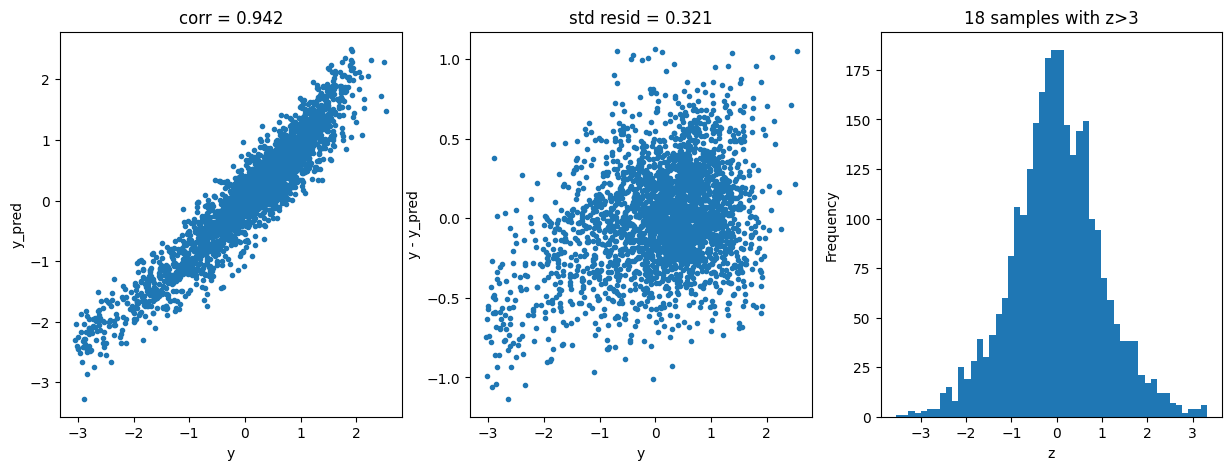

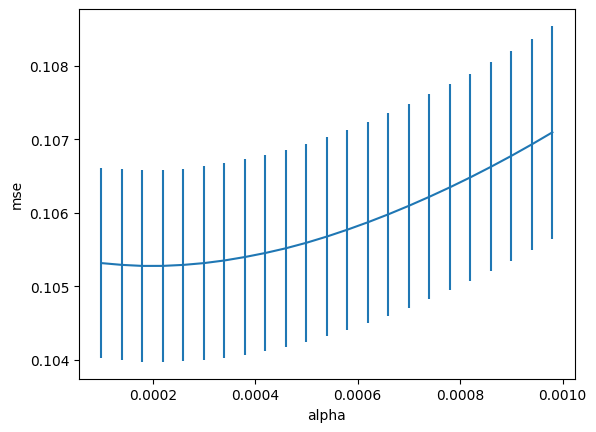

In [11]:
model = 'Lasso'

opt_models[model] = Lasso()
alphas = np.arange(1e-4,1e-3,4e-5)
param_grid = {'alpha': alphas}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        X = X,y = y,
                                                        splits=splits, repeats=repeats)

cv_score.name = model
score_models = pd.concat([score_models, cv_score.to_frame().T])

plt.figure()
plt.errorbar(alphas, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('mse')

In [12]:
grid_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'split5_test_score', 'split6_test_score', 'split7_test_score',
       'split8_test_score', 'split9_test_score', 'split10_test_score',
       'split11_test_score', 'split12_test_score', 'split13_test_score',
       'split14_test_score', 'split15_test_score', 'split16_test_score',
       'split17_test_score', 'split18_test_score', 'split19_test_score',
       'split20_test_score', 'split21_test_score', 'split22_test_score',
       'split23_test_score', 'split24_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'split5_train_score', 'split6_train_score',
       'split7_train_score', 'split8_train_score', 'split9_train

### 4.3 Elastic Net

Fitting 25 folds for each of 81 candidates, totalling 2025 fits
----------------------
ElasticNet(alpha=0.0002, l1_ratio=0.9, max_iter=10000)
----------------------
score= 0.8881476989259658
mse= 0.10285871675592337
cross_val: mean= 0.10553463017744896 , std= 0.006012232494345945


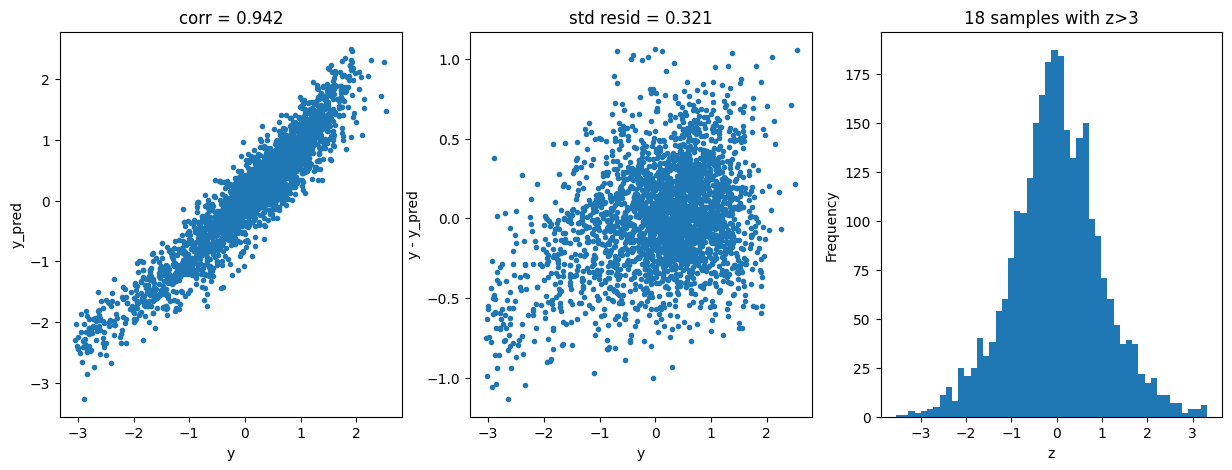

In [13]:
model ='ElasticNet'
opt_models[model] = ElasticNet(max_iter=10000)

param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
              'l1_ratio': np.arange(0.1,1.0,0.1)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        X = X,y = y,
                                                        splits=splits, repeats=repeats)

cv_score.name = model
score_models = pd.concat([score_models, cv_score.to_frame().T])

### 4.4 SVR

Fitting 25 folds for each of 5 candidates, totalling 125 fits
----------------------
SVR(C=0.9000000000000001)
----------------------
score= 0.7288219659863425
mse= 0.24937372162399024
cross_val: mean= 0.25039581022132246 , std= 0.01622304461872185


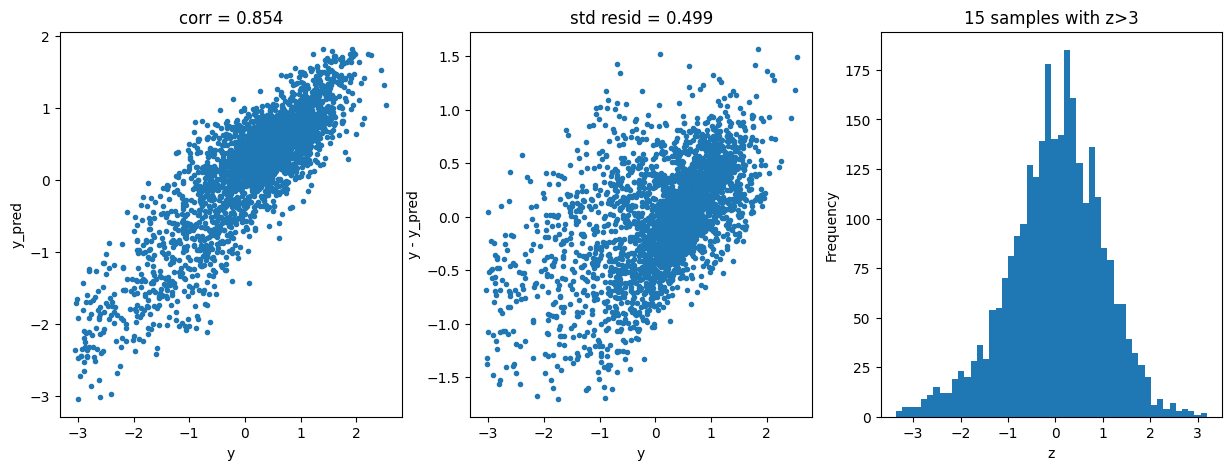

In [14]:
model='SVR'
opt_models[model] = SVR()

param_grid = {'C':np.arange(0.1,1.0,0.2)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        X = X,y = y,
                                                        splits=splits, repeats=repeats)


cv_score.name = model
score_models = pd.concat([score_models, cv_score.to_frame().T])

### 4.5 GBDT

Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------------------
GradientBoostingRegressor(max_depth=5, min_samples_split=7, n_estimators=300)
----------------------
score= 0.9932398854609966
mse= 0.006216561482670918
cross_val: mean= 0.09028581098041634 , std= 0.005956217417866306


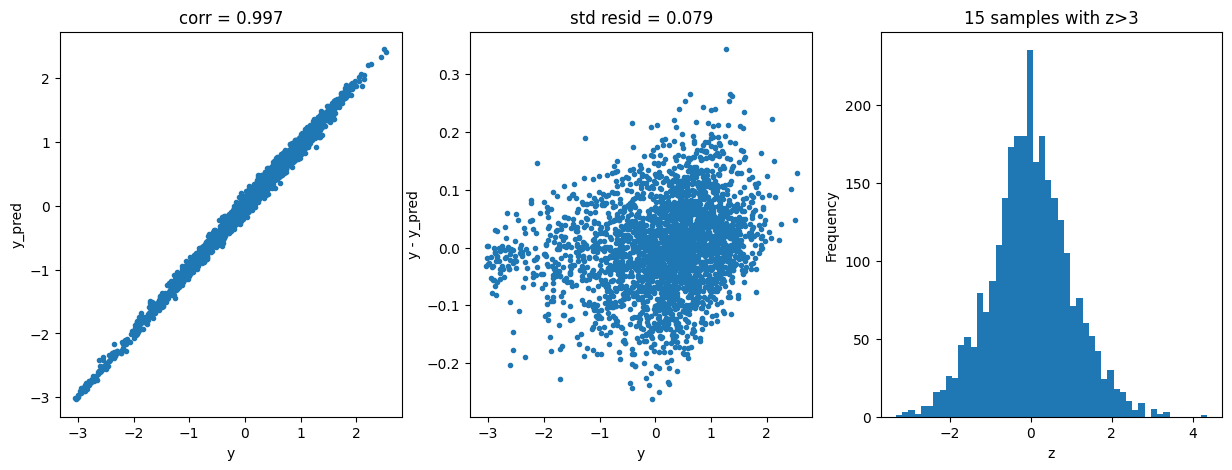

In [16]:
model = 'GradientBoosting'
opt_models[model] = GradientBoostingRegressor()

param_grid = {'n_estimators':[100,200,300],
              'max_depth':[3,5,7],
              'min_samples_split':[5,6,7]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        X = X,y = y,
                                                        splits=splits, repeats=1)

cv_score.name = model
score_models = pd.concat([score_models, cv_score.to_frame().T])

### 4.6 Random Forest

Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------------------
RandomForestRegressor(max_features=12, min_samples_split=7)
----------------------
score= 0.9772239034262115
mse= 0.02094476415588666
cross_val: mean= 0.09792045559112741 , std= 0.00775732420815118


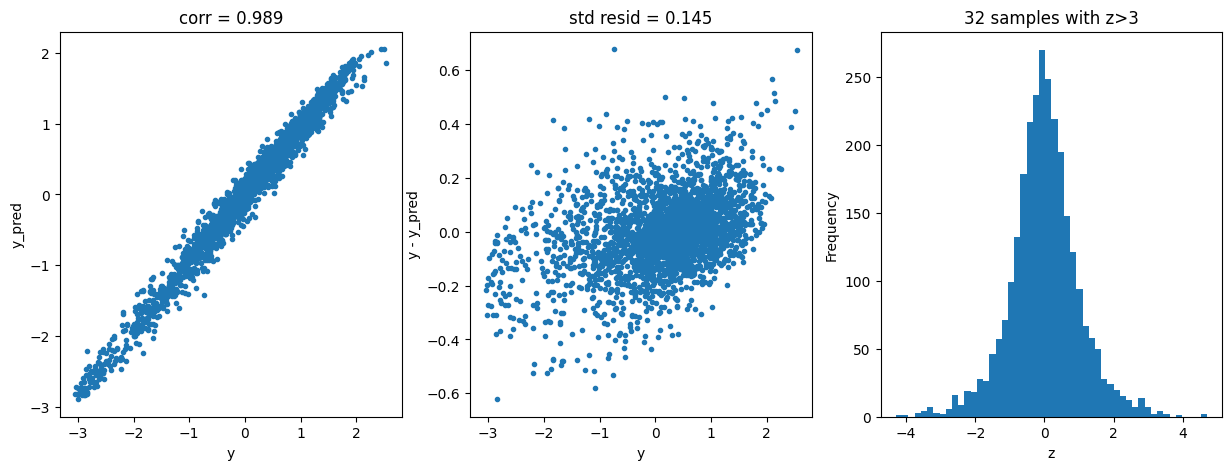

In [17]:
model = 'RandomForest'
opt_models[model] = RandomForestRegressor()

param_grid = {'n_estimators':[100,200,300],
              'max_features':[12,16,20,24],
              'min_samples_split':[5,7,9]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        X = X,y = y,
                                                        splits=splits, repeats=1)

cv_score.name = model
score_models = pd.concat([score_models, cv_score.to_frame().T])

### 4.7 Xgboost

Fitting 5 folds for each of 40 candidates, totalling 200 fits
----------------------
XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=200, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)
----------------------
score= 0.8975756285118083
mse= 0.09418884828157621
cross_val: mean= 0.1188416632132491 , std= 0.0066207032234

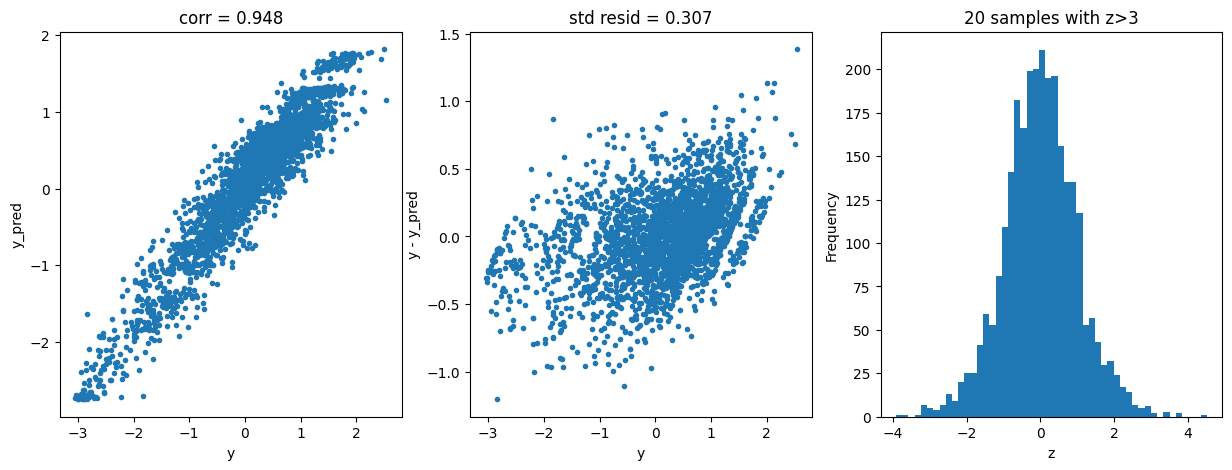

In [18]:
model = 'XGB'
opt_models[model] = XGBRFRegressor()

param_grid = {'n_estimators':[200,300],
              'max_depth':[3,5],
              'reg_lambda': np.arange(1e-5,1e-3,1e-4)}

opt_models[model], cv_score,grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        X = X,y = y,
                                                        splits=splits, repeats=1)

cv_score.name = model
score_models = pd.concat([score_models, cv_score.to_frame().T])

### 4.8 Model prediction-multi-model bagging

In [20]:
def model_predict(submit_test):
    i=0
    y_predict_total = np.zeros(submit_test.shape[0])
    
    for model in opt_models.keys():
        y_predict = opt_models[model].predict(submit_test)
        
        y_predict_total += y_predict
        
        i+=1
    # 求平均
    y_predict_mean = np.round(y_predict_total/i,3)
    
    return y_predict_mean

In [21]:
result = model_predict(submit_test)

np.savetxt('./results/bagging_result.txt',result)

In [22]:
score_models

,mean,std
Ridge,0.105259,0.004014
Lasso,0.105279,0.006506
ElasticNet,0.105535,0.006012
SVR,0.250396,0.016223
GradientBoosting,0.092059,0.006057
GradientBoosting,0.090286,0.005956
RandomForest,0.097920,0.007757
XGB,0.118842,0.006621
lightGBM,0.088682,0.004812
